In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Race 1', index_col=0)
df2 = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Race 2', index_col=0)
df3 = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Race 3', index_col=0)
df4 = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Race 4', index_col=0)
karts = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Karts', index_col=0)

<AxesSubplot:xlabel='Lap'>

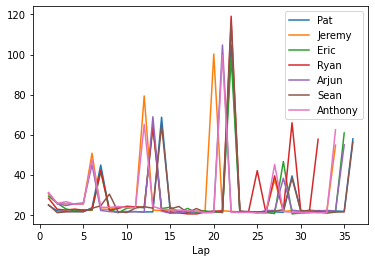

In [29]:
df1.plot()

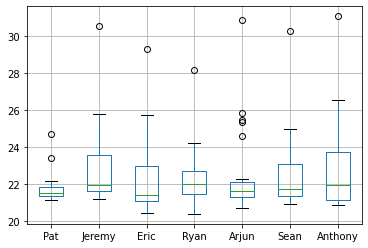

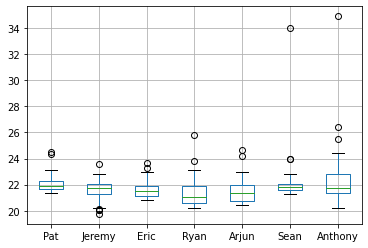

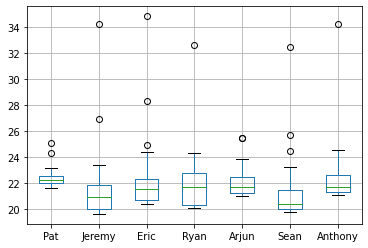

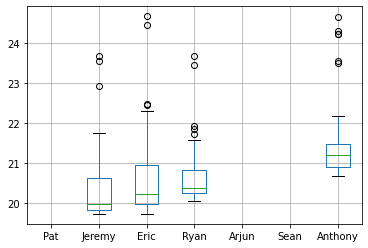

In [30]:

for df in [df1, df2, df3, df4]:
    df[df<35].boxplot()
    plt.show()

Pat seemed to be very consistent lap-to-lap with a small standard deviation.

In [36]:
df2.cumsum().loc[1].min()

23.112

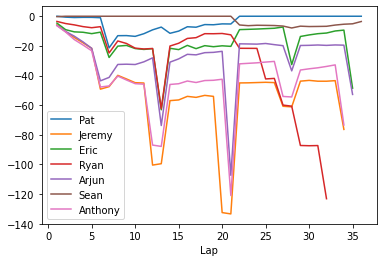

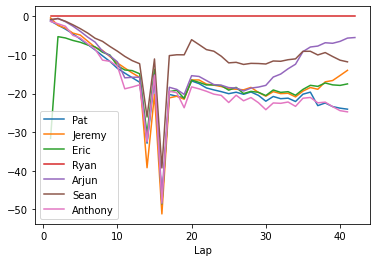

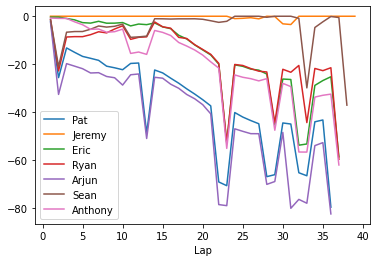

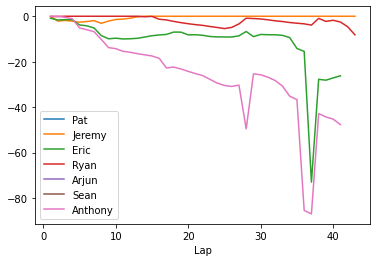

In [55]:
gaps = []
for df in [df1, df2, df3, df4]:
    gap = pd.DataFrame(index=df.index, columns=df.columns)
    for index, row in df.iterrows():
        gap.loc[index] = df.cumsum().loc[index].min()-df.cumsum().loc[index]

    gap.plot()
    gaps.append(gap)

In [7]:
karts

,Pat,Jeremy,Eric,Ryan,Arjun,Sean,Anthony
Race,,,,,,,
1,7,10,21,3,1,4,19
2,6,21,10,19,3,25,6
3,25,1,19,3,10,21,1
4,21,3,1,8,7,10,20


In [12]:
karts.loc[1]['Pat']

7

In [10]:
df1['Pat']

Lap
1      24.691
2      21.895
3      21.672
4      21.507
5      21.509
6      23.427
7      44.801
8      22.075
9      21.383
10     21.605
11     21.546
12     21.380
13     21.419
14     68.702
15     21.425
16     21.167
17     21.257
18     21.305
19     21.369
20     21.252
21     21.155
22    104.808
23     21.464
24     21.498
25     21.398
26     21.328
27     21.410
28     21.214
29     39.390
30     21.857
31     21.850
32     21.822
33     22.148
34     21.865
35     21.676
36     57.888
Name: Pat, dtype: float64

### Fastest laps

In [17]:
df = pd.concat([df1, df2, df3, df4],keys=[1,2,3,4], names=['Race Number']).reset_index()

In [18]:
df

,Race Number,Lap,Pat,Jeremy,Eric,Ryan,Arjun,Sean,Anthony
0,1,1,24.691,30.547,29.307,28.189,30.885,24.962,31.070
1,1,2,21.895,25.774,25.726,22.713,25.368,21.014,25.553
2,1,3,21.672,25.448,22.896,22.318,24.588,21.419,26.522
3,1,4,21.507,25.176,21.897,22.793,25.469,21.624,25.275
4,1,5,21.509,25.241,22.434,22.250,25.857,21.503,25.406
...,...,...,...,...,...,...,...,...,...
155,4,39,20.337,19.939,20.309,21.258,21.709,20.501,21.441
156,4,40,21.382,21.134,20.156,20.647,23.101,22.762,22.069
157,4,41,19.981,21.095,20.139,21.853,NaN,21.912,23.511
158,4,42,19.855,19.852,NaN,21.928,NaN,24.108,NaN


In [8]:
import scripts.gokarts_race as kart_race
race = kart_race.Race()
rankings = race.get_race_ranking()
rankings

,Pat,Jeremy,Eric,Ryan,Arjun,Sean,Anthony
1,1.0,6.0,3.0,7.0,4.0,2.0,5.0
2,6.0,4.0,5.0,1.0,2.0,3.0,7.0
3,6.0,1.0,3.0,4.0,7.0,2.0,5.0
4,3.0,1.0,5.0,2.0,7.0,4.0,6.0


In [5]:
points = kart_race.Points()
points.mario_kart_points()

{1: 15, 2: 12, 3: 10, 4: 9, 5: 8, 6: 7, 7: 6}

In [15]:
rankings.replace(points.mario_kart_points()).sum().sort_values(ascending=False)

Jeremy     46.0
Sean       43.0
Ryan       42.0
Pat        39.0
Eric       36.0
Arjun      33.0
Anthony    29.0
dtype: float64

In [13]:
rankings.replace(points.mario_kart_points()).sum().rank(ascending=False).sort_values()

Jeremy     1.0
Sean       2.0
Ryan       3.0
Pat        4.0
Eric       5.0
Arjun      6.0
Anthony    7.0
dtype: float64

In [16]:
rankings.replace(points.f1_position_points()).sum().sort_values(ascending=False)

Jeremy     70.0
Sean       63.0
Ryan       61.0
Pat        56.0
Eric       50.0
Arjun      42.0
Anthony    34.0
dtype: float64

In [17]:
rankings.replace(points.f1_sprint_points()).sum().sort_values(ascending=False)

Sean       25.0
Jeremy     24.0
Ryan       22.0
Pat        20.0
Eric       20.0
Arjun      16.0
Anthony    13.0
dtype: float64

In [4]:
race.get_average_lap()

,Pat,Jeremy,Eric,Ryan,Arjun,Sean,Anthony
1,27.448833,28.969,27.965486,30.865375,28.086286,27.547528,28.881647
2,23.784268,23.539122,23.624805,23.136143,23.267357,23.485659,23.801195
3,26.8505,24.985,26.104703,26.132784,26.928556,25.367974,26.196946
4,23.128548,22.61686,23.389488,22.806837,24.458875,23.3305,23.91378


In [60]:
class Race:
    def __init__(self, race_number):
        self.race_number = race_number
        self.race_results = pd.read_excel('data/processed/Manual times.xlsx', sheet_name='Race ' + str(self.race_number), index_col=0)

    def get_race_results(self):
        return self.race_results


In [61]:
race = Race(1)
race